In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='\data',download=True,transform=ToTensor())

In [3]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset,(train_size,val_size))
len(train_ds),len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

#  num_workers enables parallel data loading by using multiple worker processes, 
#  pin_memory determines whether to use pinned memory for faster data transfer to the GPU. 

train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size*2,shuffle=True,num_workers=4,pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


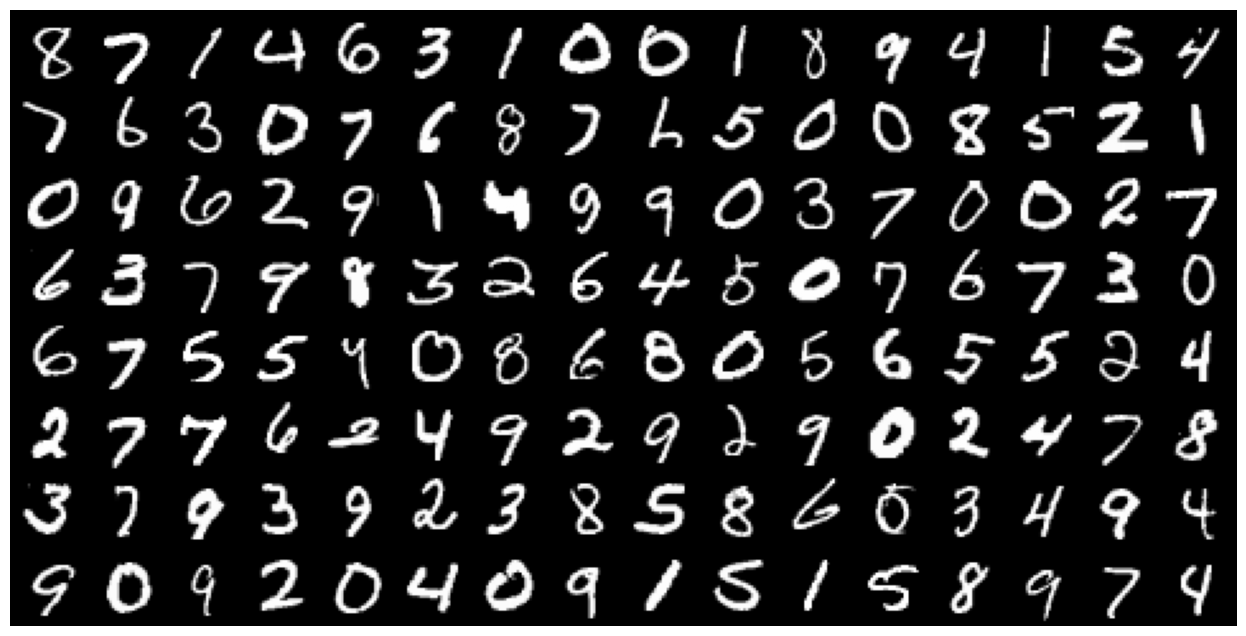

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    #make_gird help to visulize the batch images to one plot
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Define the Model

In [7]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        # xb.size(0) returns the batch size and -1 indicates that torch will automatically calculate other dimensions
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [10]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3205268383026123
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2774,  0.1055,  0.0168, -0.0122,  0.0158, -0.2336, -0.1432,  0.0274,
          0.0108,  0.1302],
        [ 0.2295,  0.1653, -0.0007, -0.0559,  0.0326, -0.1327, -0.0295,  0.0115,
          0.0409,  0.1408]])


In [13]:
torch.cuda.is_available()

True

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device  

'cuda'

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [16]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [17]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [20]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([7, 8, 1, 6, 9, 3, 9, 1, 7, 3, 1, 0, 4, 6, 3, 3, 0, 1, 6, 7, 0, 4, 2, 3,
        3, 9, 9, 2, 1, 6, 1, 7, 6, 3, 1, 8, 4, 4, 6, 9, 7, 6, 1, 0, 1, 3, 3, 1,
        0, 5, 6, 5, 0, 5, 1, 4, 2, 9, 3, 6, 9, 9, 8, 1, 9, 6, 1, 8, 6, 3, 0, 8,
        7, 5, 8, 7, 4, 8, 6, 6, 6, 6, 7, 1, 7, 8, 9, 6, 4, 1, 6, 0, 0, 4, 2, 6,
        3, 9, 8, 5, 9, 8, 1, 4, 9, 4, 1, 2, 7, 9, 8, 4, 0, 0, 5, 3, 7, 1, 1, 9,
        6, 8, 6, 2, 3, 9, 3, 6, 6, 1, 4, 4, 5, 5, 1, 3, 1, 9, 4, 5, 6, 7, 7, 2,
        7, 2, 7, 8, 3, 1, 2, 5, 5, 9, 7, 1, 6, 7, 3, 1, 8, 0, 2, 0, 0, 1, 5, 1,
        0, 9, 8, 1, 6, 3, 1, 1, 5, 2, 5, 0, 8, 1, 0, 3, 6, 7, 9, 9, 9, 7, 6, 2,
        6, 8, 0, 1, 9, 4, 7, 5, 2, 5, 2, 7, 4, 2, 0, 0, 7, 6, 1, 0, 1, 4, 8, 7,
        3, 1, 0, 2, 5, 4, 1, 2, 5, 9, 4, 2, 2, 2, 8, 7, 4, 2, 3, 2, 8, 7, 7, 3,
        5, 9, 8, 8, 7, 2, 0, 4, 7, 5, 0, 3, 8, 2, 4, 1], device='cuda:0')


Training the Model

In [21]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
model.to(device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.2989025115966797, 'val_acc': 0.1171875}]

In [24]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2696, val_acc: 0.9226
Epoch [1], val_loss: 0.1894, val_acc: 0.9435
Epoch [2], val_loss: 0.1475, val_acc: 0.9580
Epoch [3], val_loss: 0.1642, val_acc: 0.9529
Epoch [4], val_loss: 0.1385, val_acc: 0.9604


In [25]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1330, val_acc: 0.9606
Epoch [1], val_loss: 0.1244, val_acc: 0.9643
Epoch [2], val_loss: 0.1310, val_acc: 0.9594
Epoch [3], val_loss: 0.1273, val_acc: 0.9641
Epoch [4], val_loss: 0.1523, val_acc: 0.9582


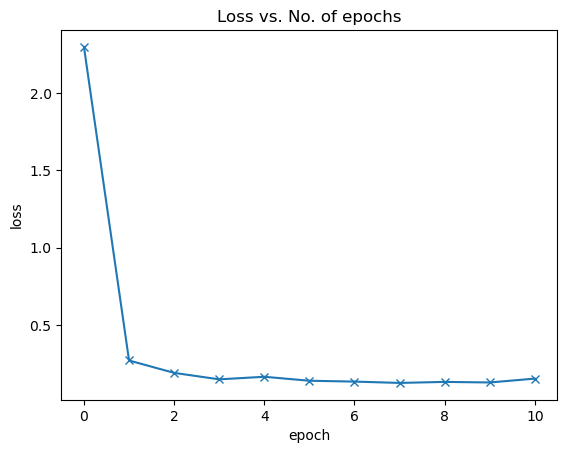

In [26]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

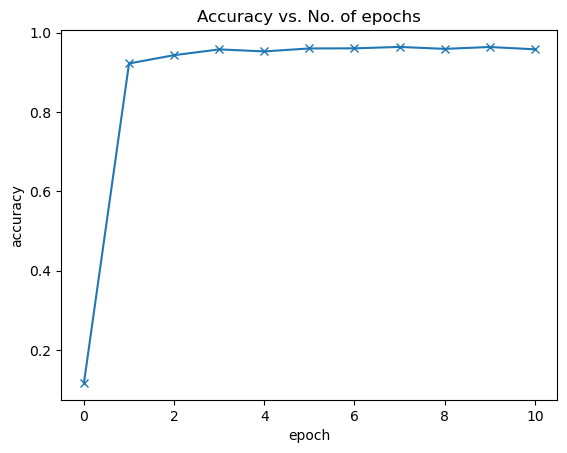

In [27]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Testing with indivdual images

In [28]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [29]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


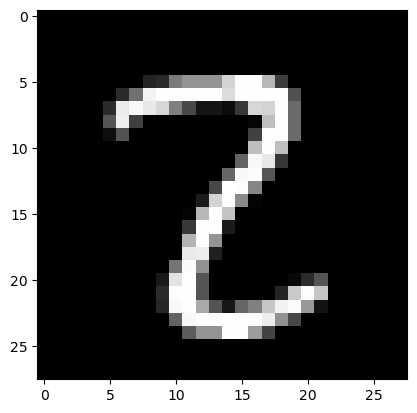

In [30]:
#previous logistic regression has predicted 8 but now 2.
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 8


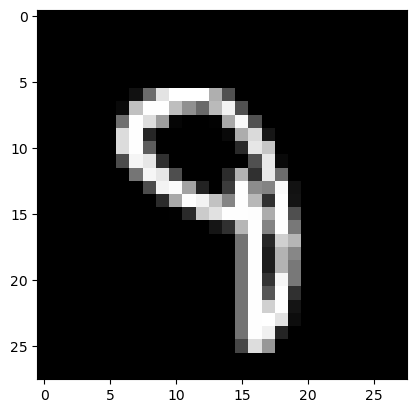

In [31]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [32]:
test_loader = DeviceDataLoader(DataLoader(test_dataset,batch_size=256),device)
result = evaluate(model,test_loader)
result

{'val_loss': 0.13669167459011078, 'val_acc': 0.9619140625}

In [33]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')